# Analyze Sparse + Smooth signal with an inverse problem
This nootbook presents the main results of my project

In [1]:
from src import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Sparse + Smooth signal
We have our simulated Sparse + Smooth signal

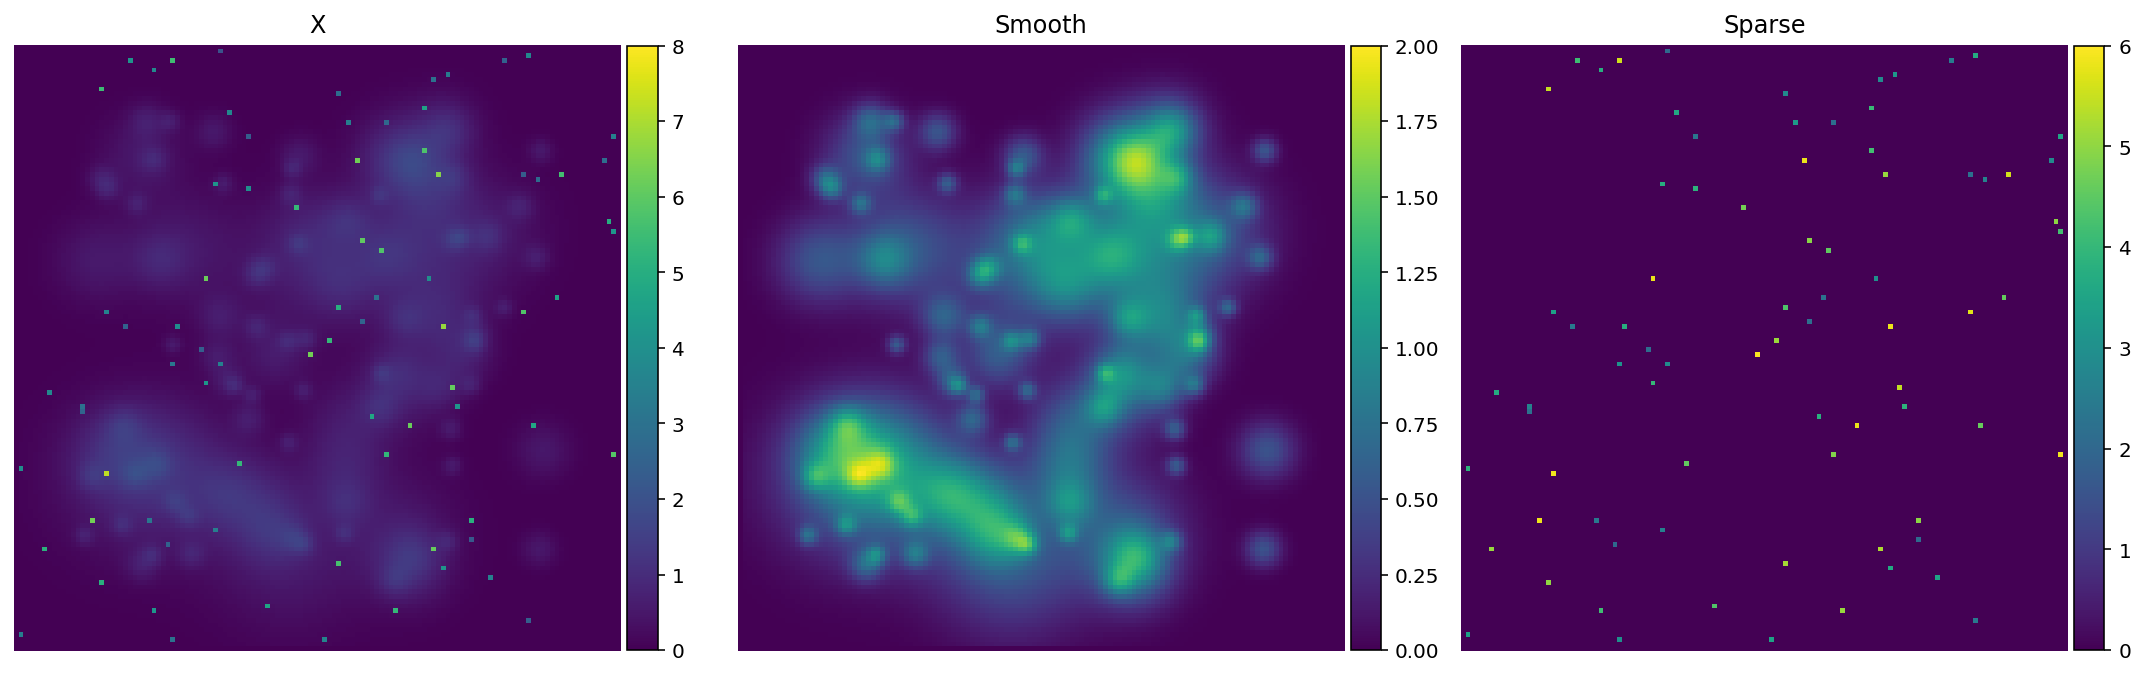

In [3]:
d = (128, 128) # Dimensions of our image
seed = 42
s = SparseSmoothSignal(d) # Our simulated sparse + smooth signal
s.random_sparse(seed)
s.random_smooth(seed)
s.plot()

## Hyperparameters

In [4]:
L = 0.1 # Number of measurements in percentage
l1 = 0.02 # lambda 1 - weight of the L1 penalty
l2 = 0.1 # lambda 2 - weight of the L2 penalty
psnr = 50. # PSNR added
s.psnr = psnr
s.H = get_low_freq_operator(d, L) # Measurement operator used
l2_op = get_L2_operator(d, "Laplacian") # Smoothing Operator of the L2 penalty term, here a Laplacian

## Reconstruction 
We have made a reconstruction with the parameters above.

CPU times: total: 4.72 s
Wall time: 23.7 s


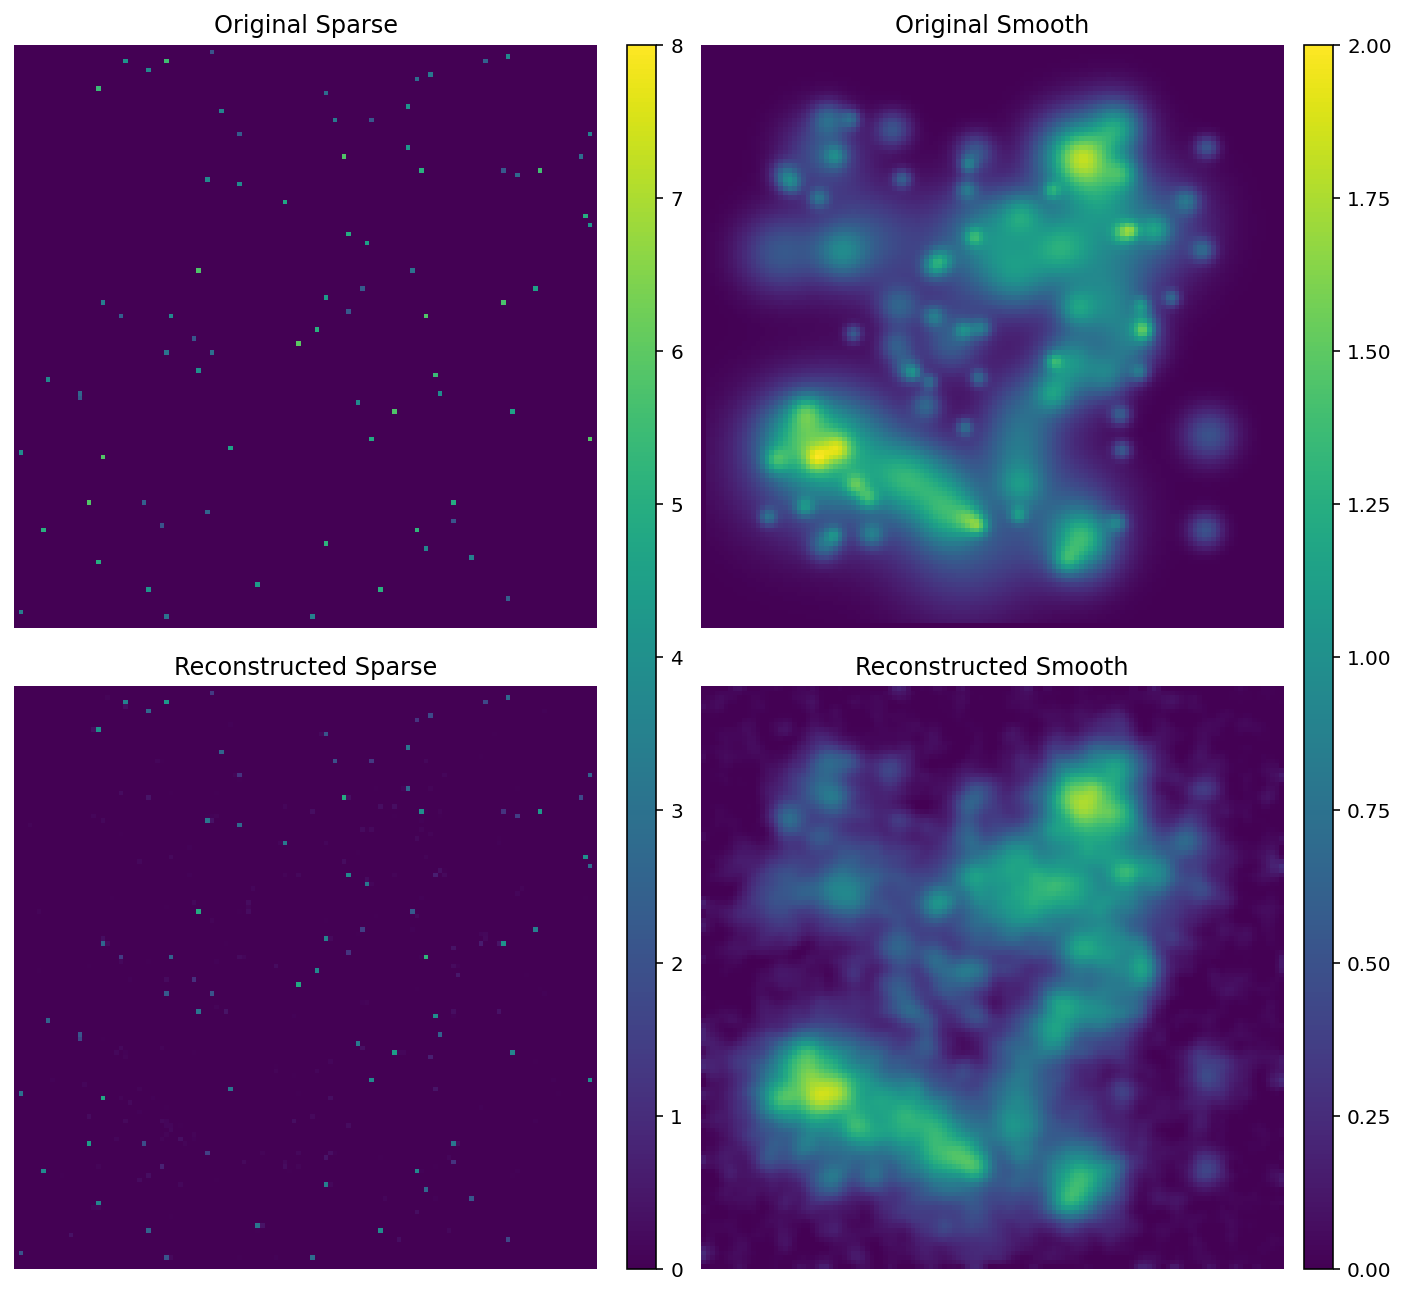

In [5]:
%%time
x1, x2 = solve(s, l1, l2, l2_op)
plot_reconstruction(s.sparse, s.smooth, x1, x2)

## Performance

In [6]:
%%time
d_1000 = (1000, 1000)
s_1000 = SparseSmoothSignal(d_1000)
s_1000.H = get_low_freq_operator(d_1000, L) 

CPU times: total: 6.95 s
Wall time: 6.8 s


In [ ]:
%%time
l2_op_1000 = get_L2_operator(d_1000, "Laplacian")

In [ ]:
%%time
x1_1000, x2_1000 = solve(s_1000, l1, l2, l2_op_1000)
plot_reconstruction(s_1000.sparse, s_1000.smooth, x1_1000, x2_1000)
found, wrong = peaks_found(s_1000.sparse, x1_1000, 1)
print(f"Number of peaks : {len(np.argwhere(s.sparse >= 2))}")
print(f"Peaks found : {found}")
print(f"Wrong peaks found : {wrong}")
intensity = peaks_intensity(s_1000.sparse, x1_1000)
print(f"Mean intensity of the reconstructed peaks : {np.mean(intensity):.1%}")

In [ ]:
# clearing heavy variables
del d_1000
del s_1000
del l2_op_1000
del x1_1000
del x2_1000

## Sampling Methods
We have 3 different sampling methods that can be used. The first is by taking the highest fourier coeffcient of the signal ploted on the left. The second is just a random uniform samping. The third is mix with a part that samples the low frequency with a gaussian and the other part samples uniformly from the rest of the pixel.

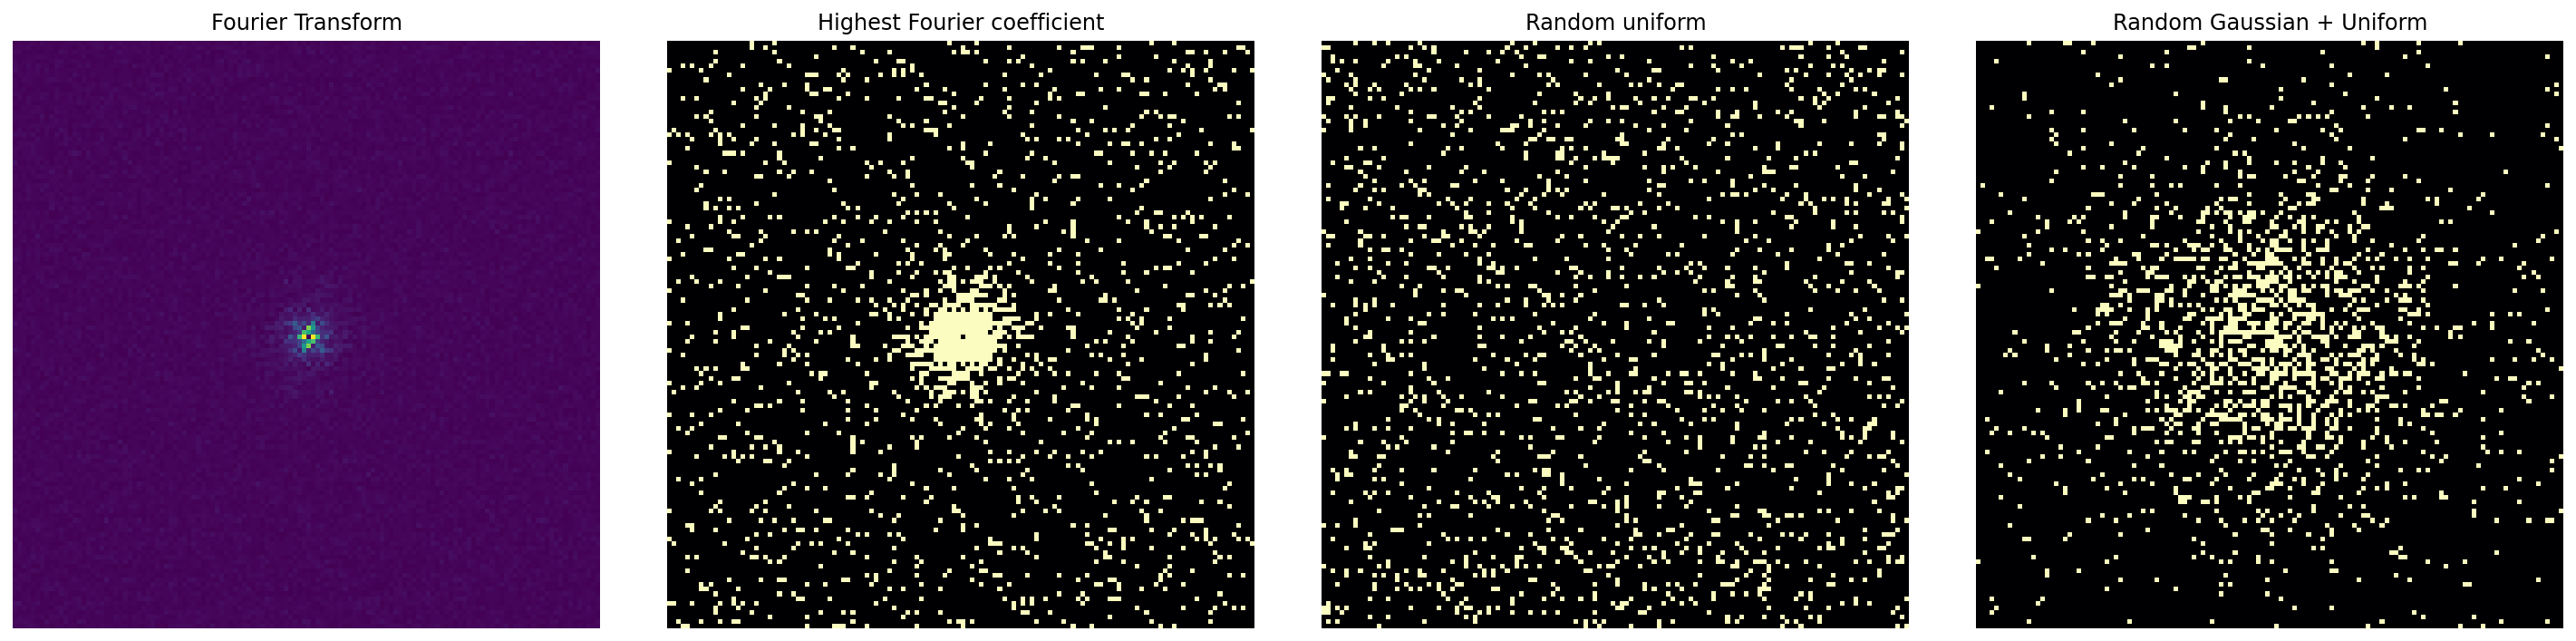

In [10]:
plot_sampling_methods(s, L)

We see that for the smooth component as long as we can sample the important coefficient we have a good reconstruction. We also notice that the sparse component is better reconstruct with a uniform sampling even slightly better than the highest fourier coeffcient.

Mean intensity of the reconstructed peaks (Highest Fourier coefficient) : 84.5%
Mean intensity of the reconstructed peaks (Random uniform) : 90.1%
Mean intensity of the reconstructed peaks (Random Gaussian + Uniform) : 61.8%


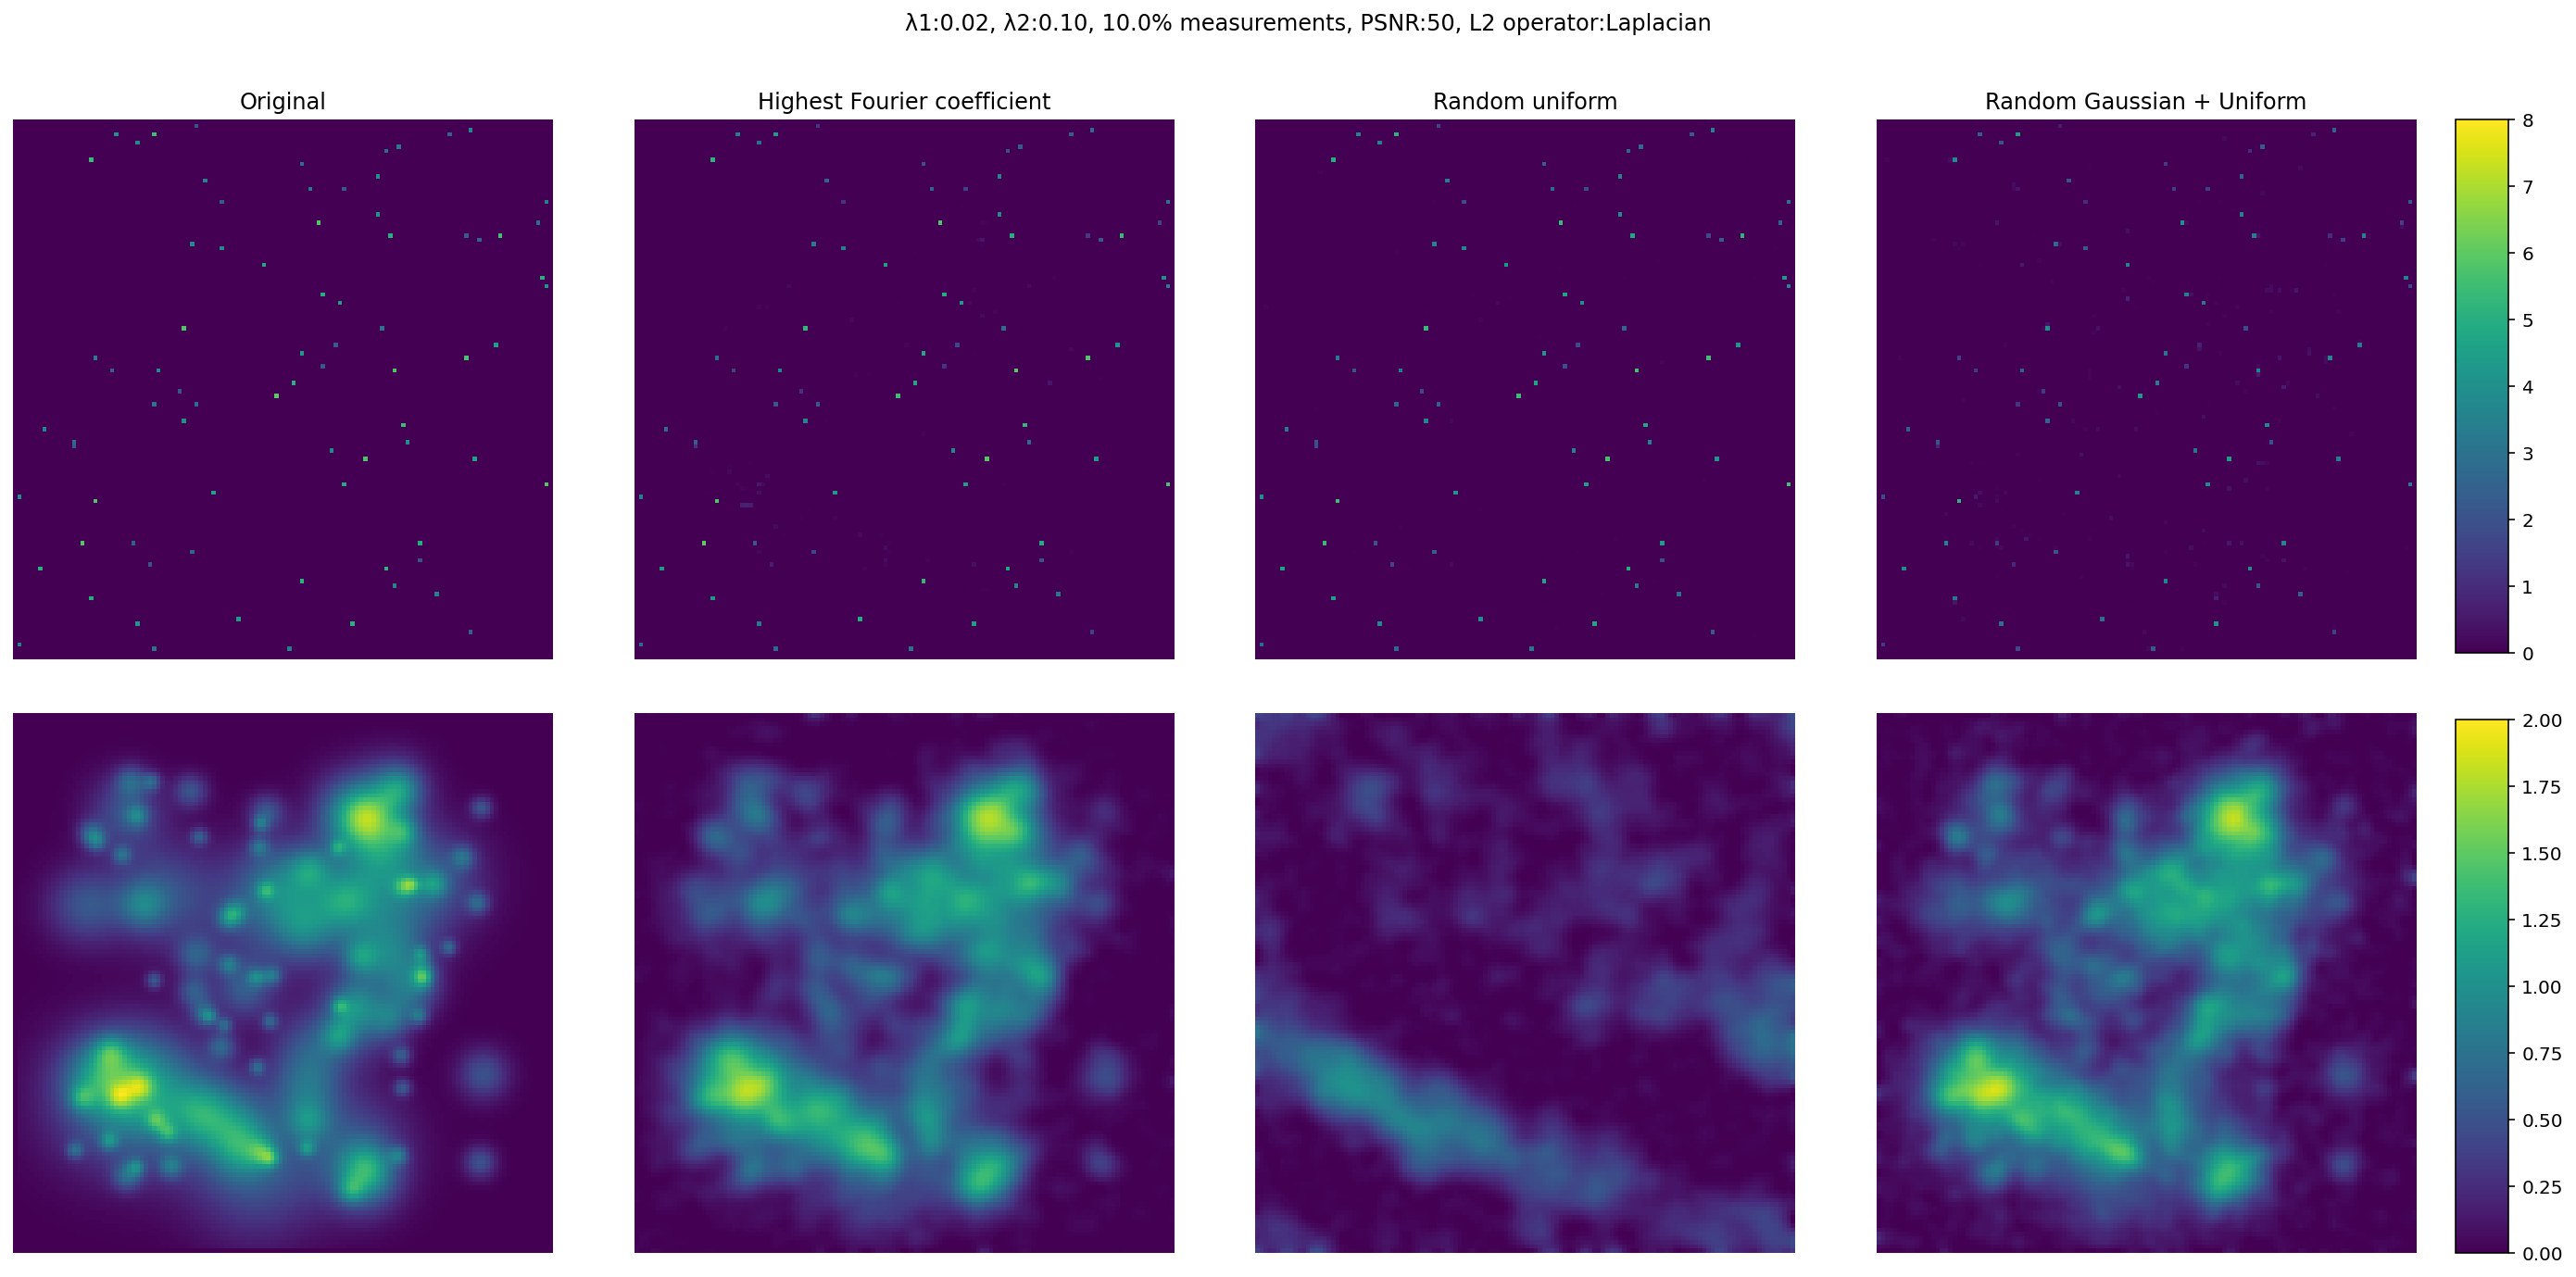

In [11]:
compare_measurements_methods(s, L, l1, l2, psnr, "Laplacian")

With noise the best method remains the highest fourier coeffcient.

Mean intensity of the reconstructed peaks (Highest Fourier coefficient) : 50.4%
Mean intensity of the reconstructed peaks (Random uniform) : 30.7%
Mean intensity of the reconstructed peaks (Random Gaussian + Uniform) : 16.5%


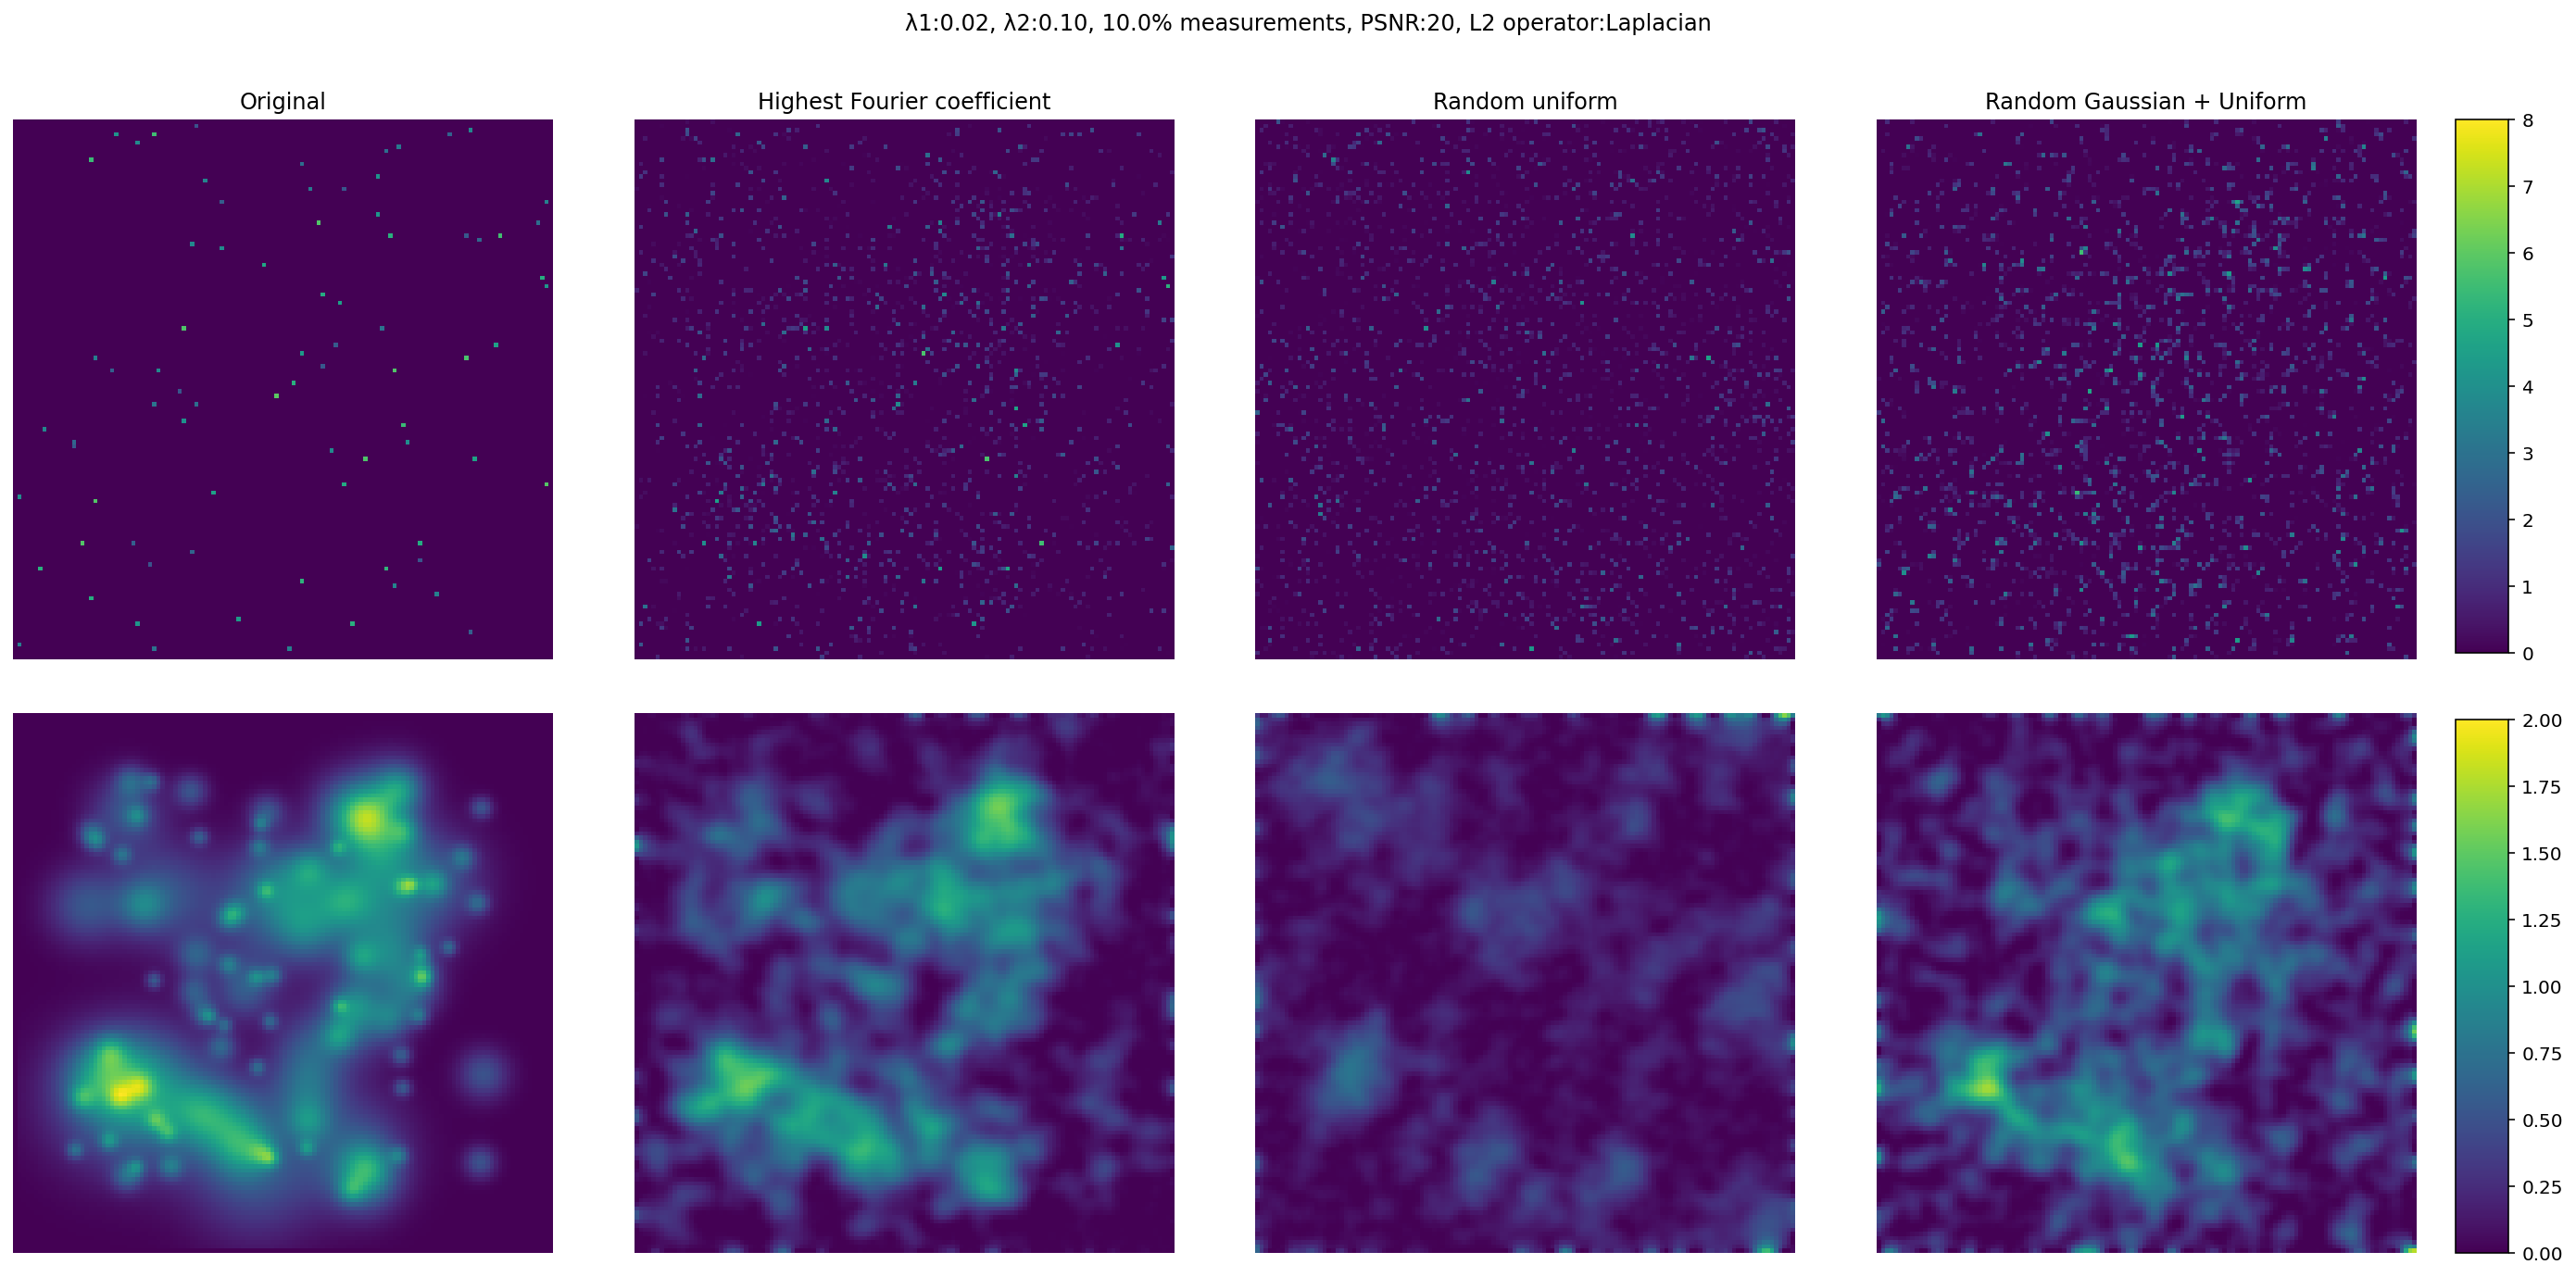

In [12]:
s.psnr = 20.
compare_measurements_methods(s, L, l1, l2, 20, "Laplacian")

## Smoothing operator
The smoothing operator really help with the smooth component, it smooth the result and also eliminates the peaks of the sparse component on the smooth one.

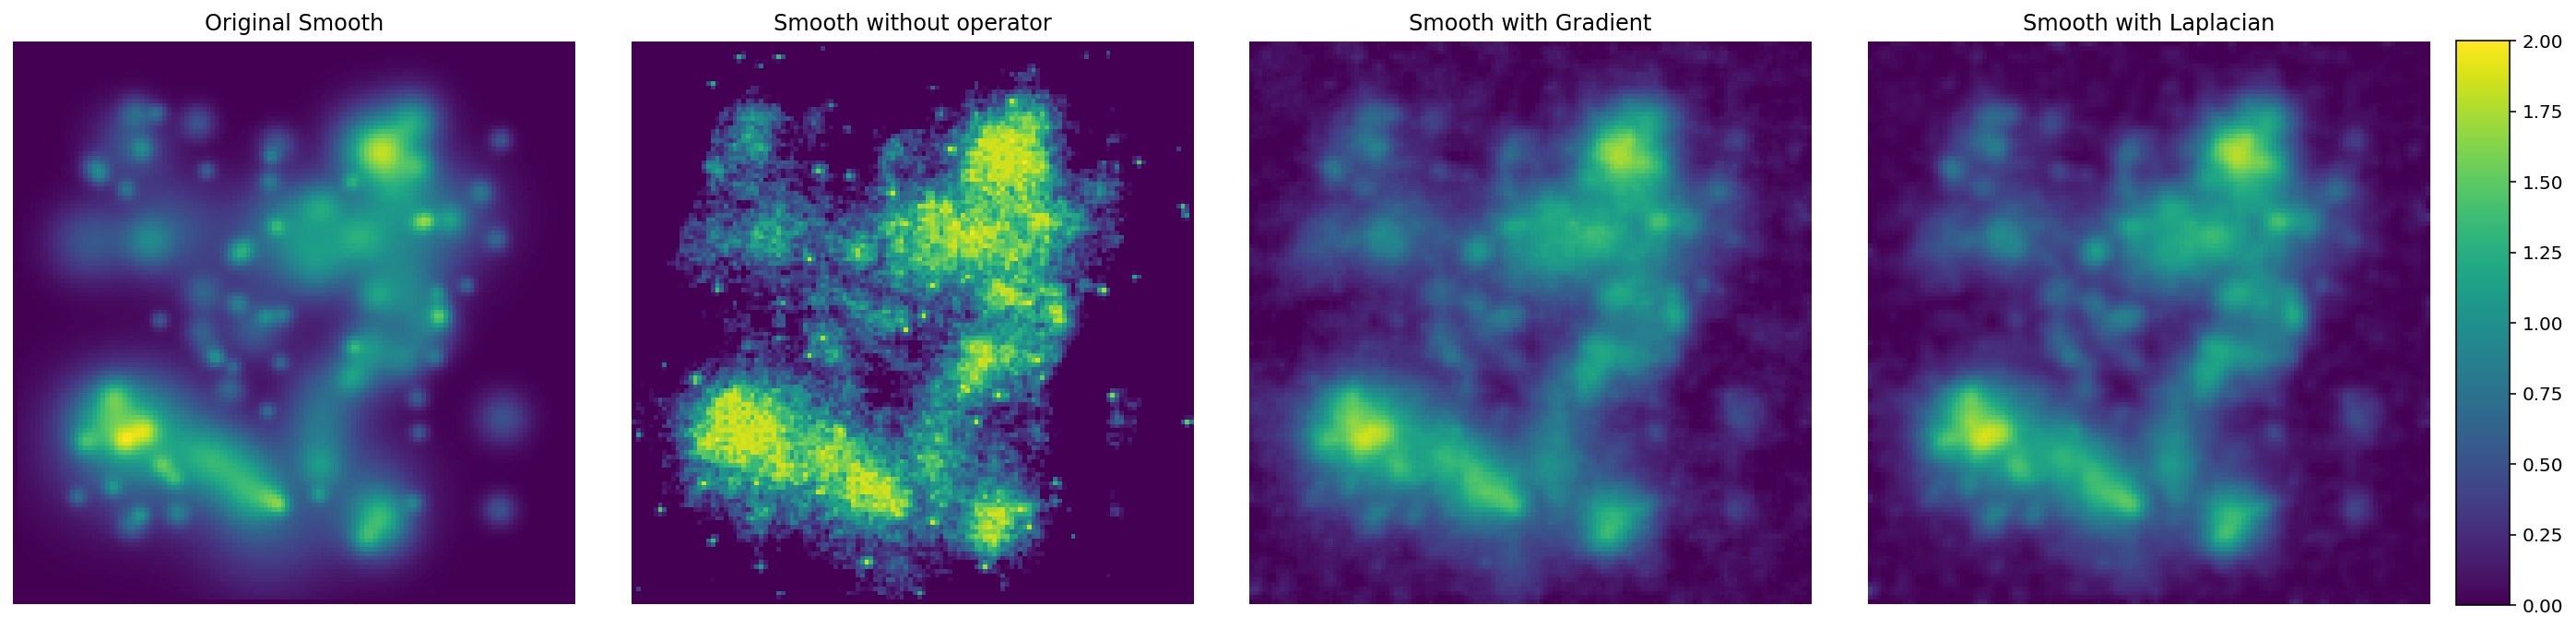

In [13]:
s.psnr = 50.
compare_smoothing_operator(s)

It works even better when we have noise

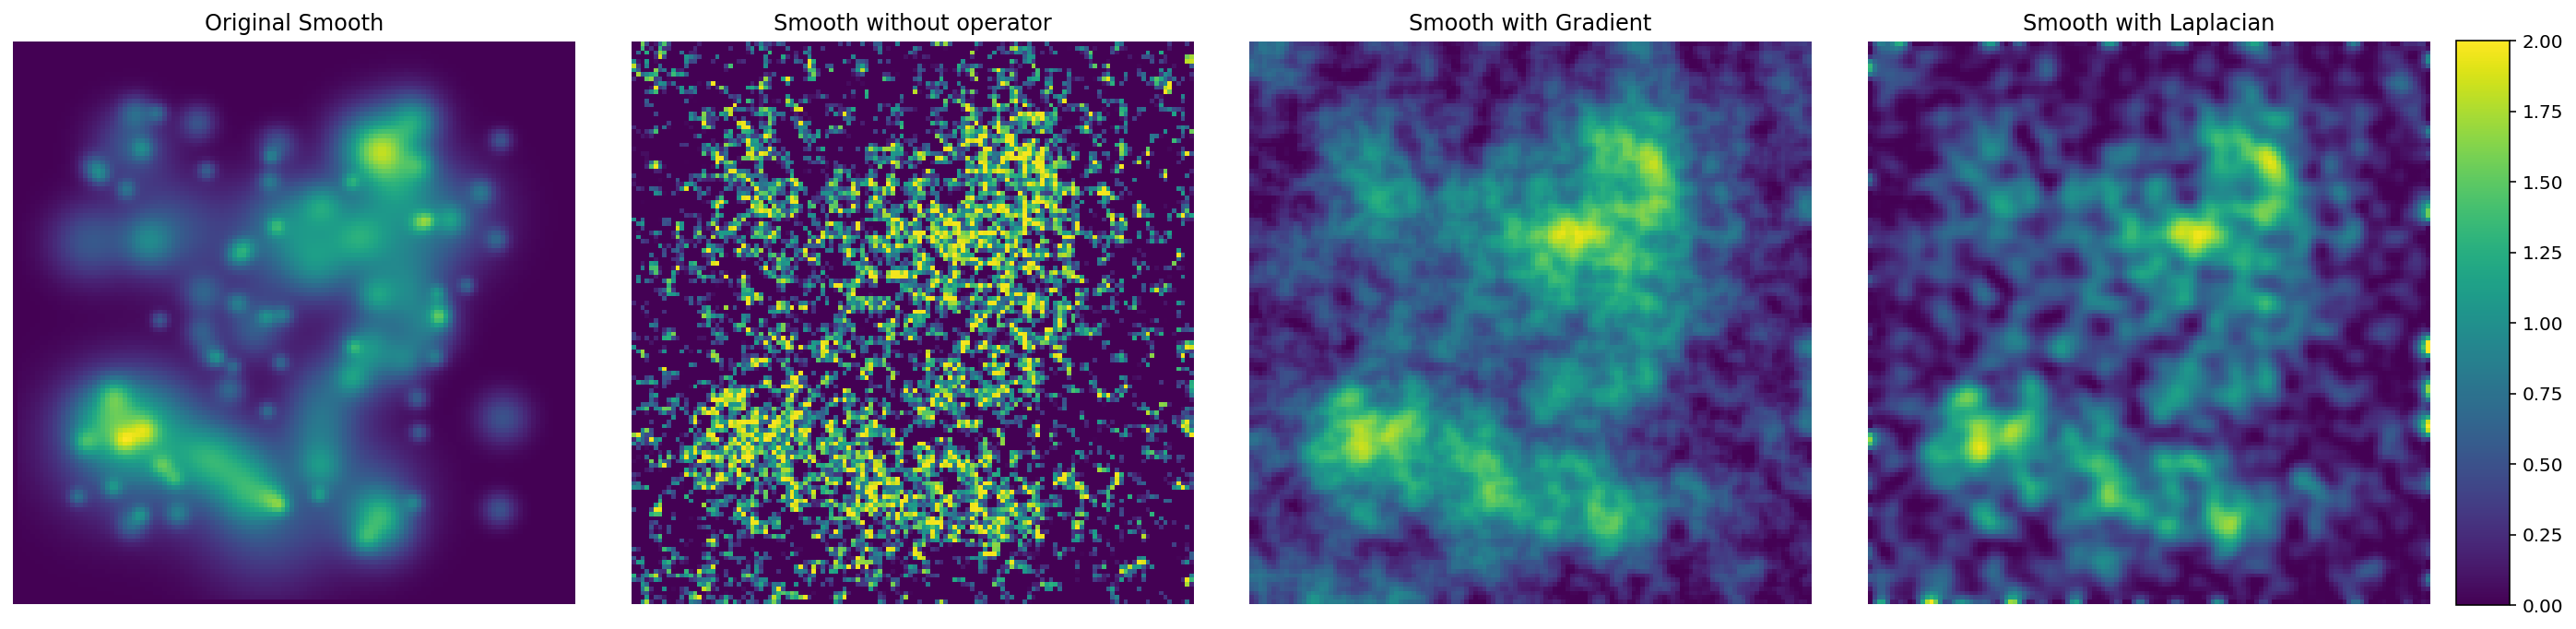

In [14]:
s.psnr = 20.
compare_smoothing_operator(s)

We see that without the smoothing operator we can't have a good reconstruction for both componant. If $\lambda_2$ is too big compare to $\lambda_1$ then the sparse componant contains smooth pixels and the smooth is really low energy. When $\lambda_2$ is too low then the sparse component is zero and the smooth component start to have the sparse peaks in it like above.

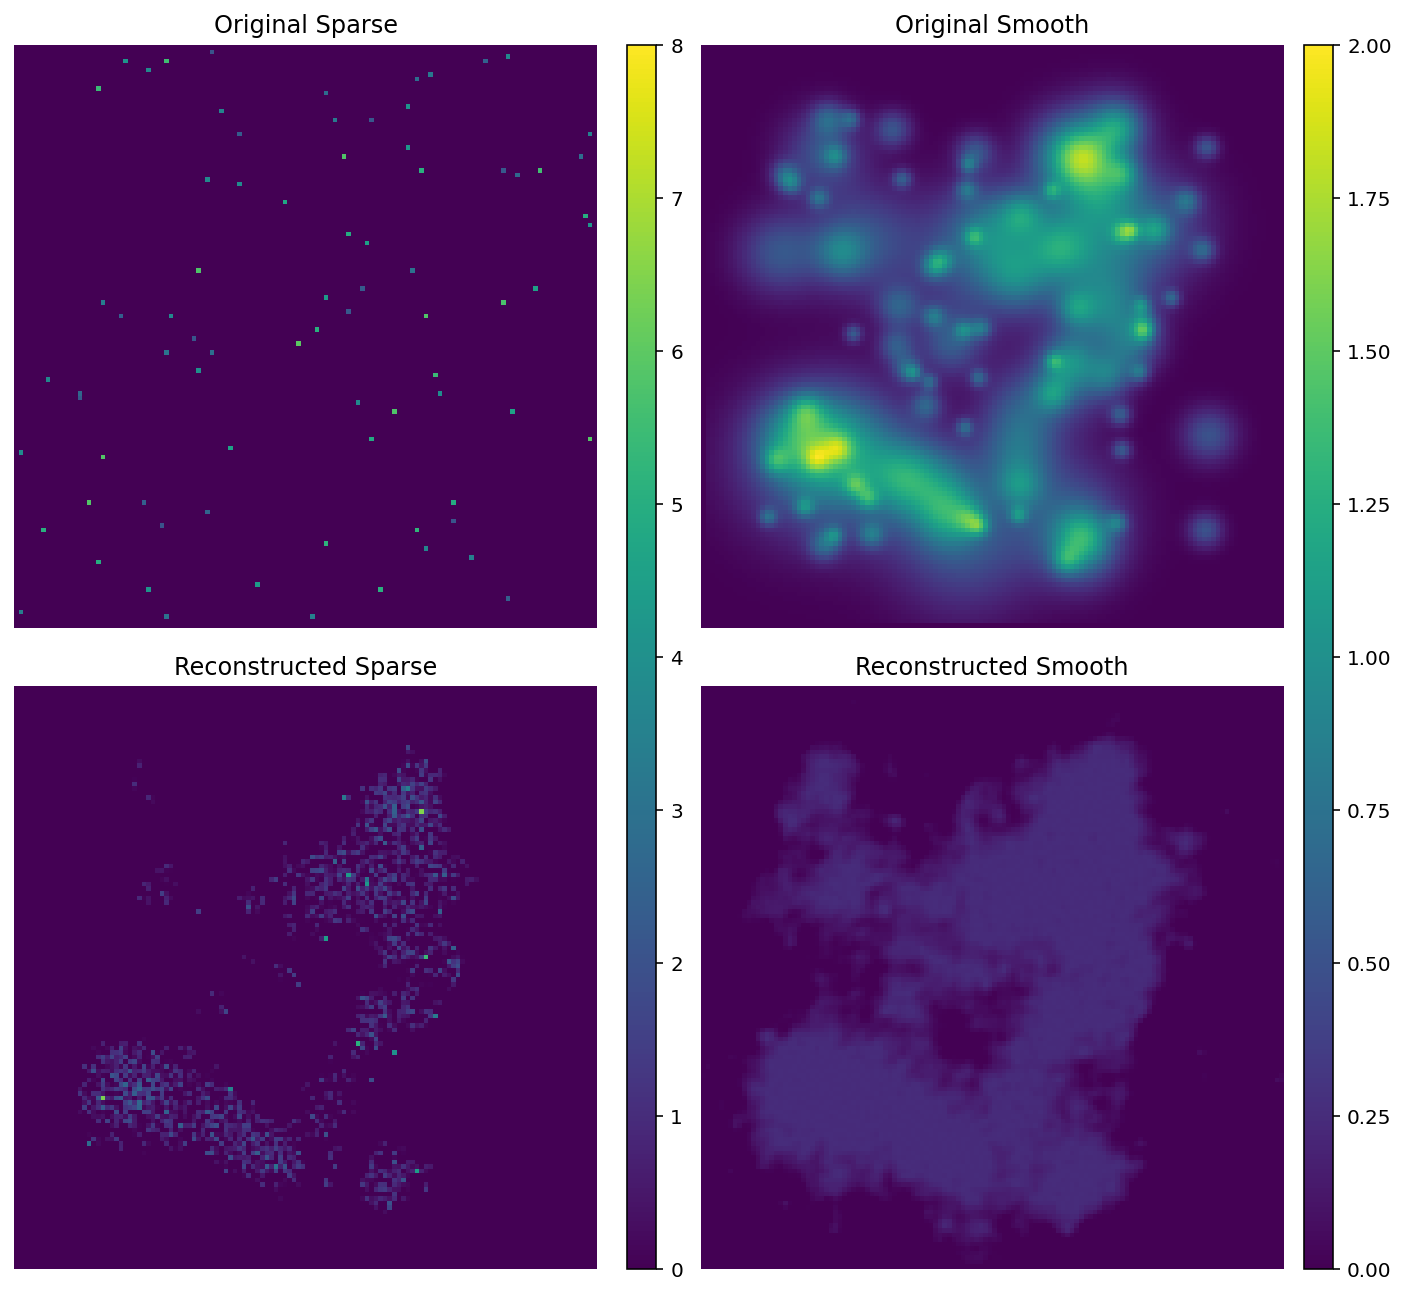

In [15]:
s.psnr = 50.
x1, x2 = solve(s, 0.1, 0.2, None)
plot_reconstruction(s.sparse, s.smooth, x1, x2)

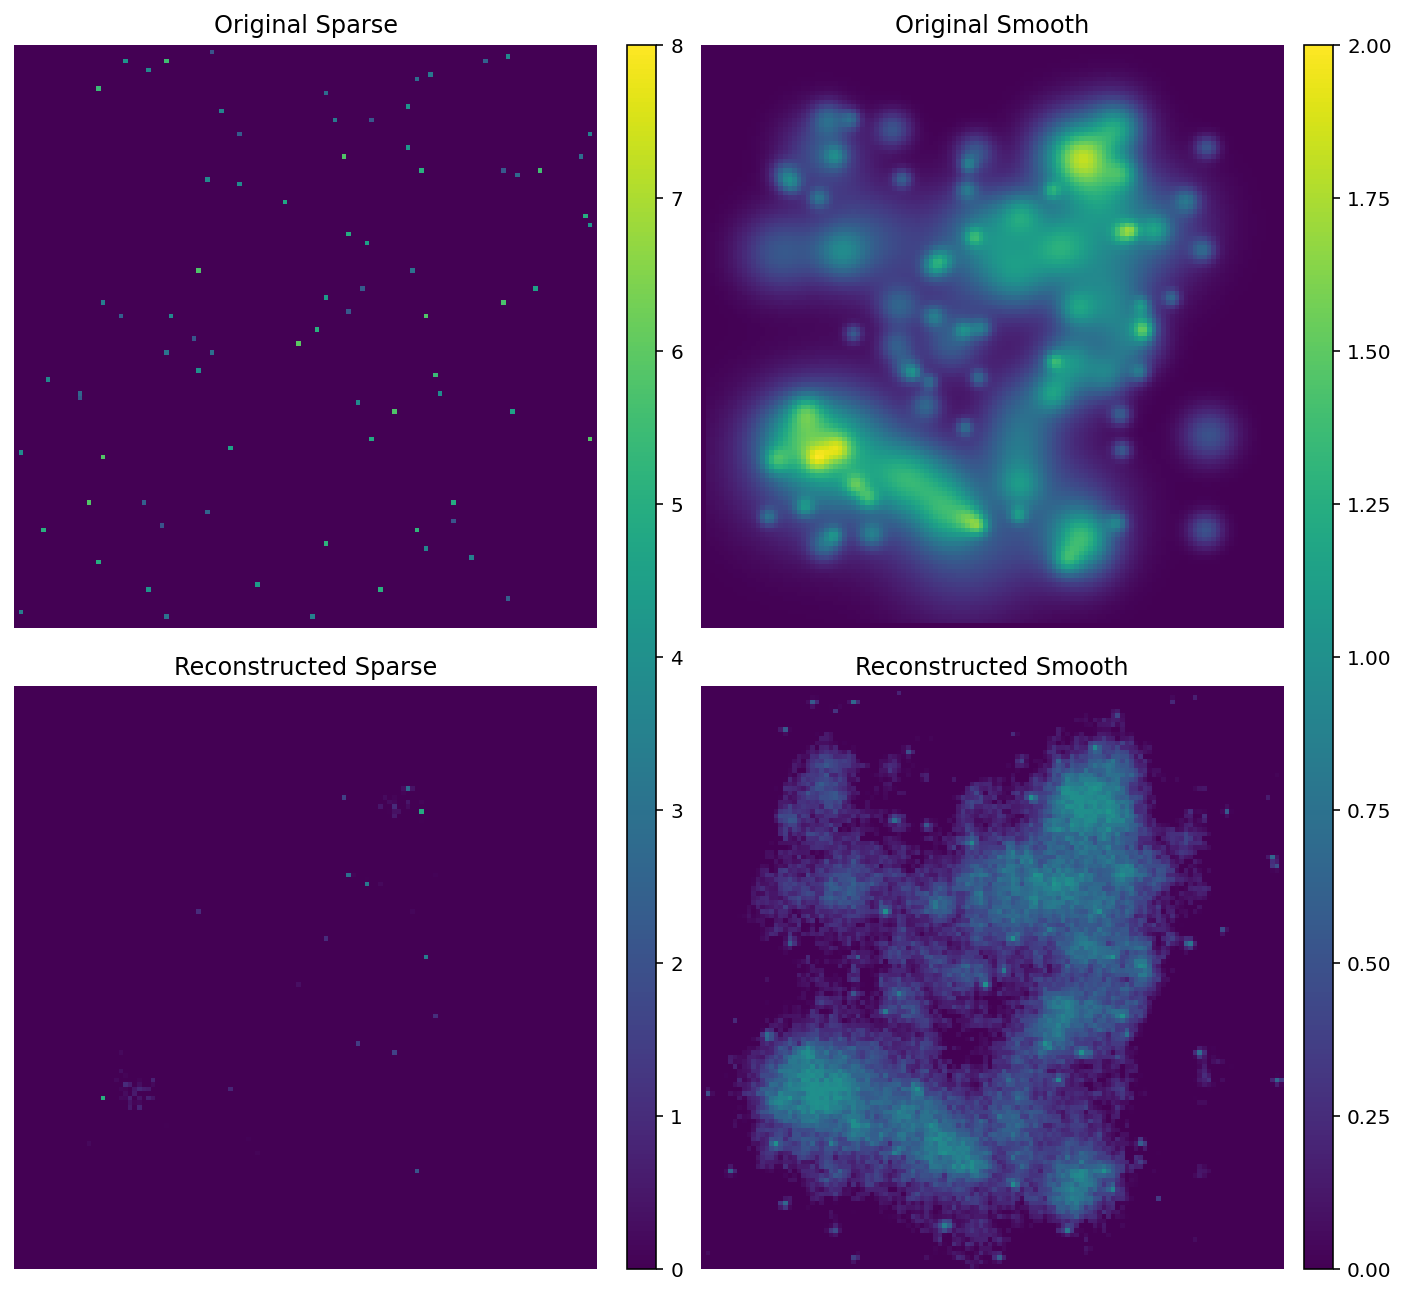

In [16]:
s.psnr = 50.
x1, x2 = solve(s, 0.2, 0.1, None)
plot_reconstruction(s.sparse, s.smooth, x1, x2)

## Study of $\lambda_1$ and $\lambda_2$
Here we try to find the "best" $\lambda_1$ and $\lambda_2$ to use and what impact they have. 

First we try to change $\lambda_1$ for some fix $\lambda_2$ and we plot the loss. We also ploted the number of peaks recoverd in the sparse component. In the last plot we have studied the value of some pixels of the sparse reconstruction as $\lambda_1$ cahnge.

In [ ]:
test_lambda1(s, L, lambda1_min=0.001, lambda1_max=0.3, nb=50, lambda2=0.1, operator_l2="Laplacian", psnr=50., threshold=0.75)

Here we have done the same for $\lambda_2$

In [ ]:
test_lambda2(s, L, lambda2_min=0.001, lambda2_max=0.3, nb=50, lambda1=0.02, operator_l2="Laplacian", psnr=50., threshold=0.75)

## Reconstruction with noise
The reconstruction with noise is really complicated.

With 30 PSNR, we can't recoved the sparse component, we can just get some of the peaks back. For the smooth one we can recover a signal that is a bit noisy.

In [ ]:
s.psnr = 30.
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)
found, wrong =  peaks_found(s.sparse, x1, 2)
print(f"Peaks found : {found}")
print(f"Wrong peaks found : {wrong}")

With 20 PSNR the smooth component start to become really noisy and the sparse is just like random

In [ ]:
psnr = 20.
s.psnr = psnr
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)
found, wrong = peaks_found(s.sparse, x1, 2)
print(f"peaks found : {found}")
print(f"wrong peaks found : {wrong}")

With 0 PSNR we just get noise

In [ ]:
psnr = 0.
s.psnr = psnr
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)
found, wrong = peaks_found(s.sparse, x1, 2)
print(f"peaks found : {found}")
print(f"wrong peaks found : {wrong}")

We can try to change our penalty weights to have a better recovery, but we can see that it is impossible by just changing these two parameters to have a better recovery.

In [ ]:
test_lambda1(s, L, lambda1_min=0.001, lambda1_max=0.3, nb=50, lambda2=0.1, operator_l2="Laplacian", psnr=psnr)

In [ ]:
test_lambda2(s, L, lambda2_min=0.001, lambda2_max=0.3, nb=50, lambda1=0.05, operator_l2="Laplacian", psnr=psnr)

Taking more measurements helps a bit, but doesn't solve the problem either

In [ ]:
psnr = 20.
s.psnr = psnr
s.H = get_low_freq_operator(d, 0.25) # 25% of measurements
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)
found, wrong = peaks_found(s.sparse, x1, 2)
print(f"peaks found : {found}")
print(f"wrong peaks found : {wrong}")

In [ ]:
test_lambda1(s, L, lambda1_min=0.001, lambda1_max=0.2, nb=50, lambda2=None, operator_l2="Laplacian", psnr=psnr)